In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Consturction

In [3]:
train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')
train_data = train_file['data']
print("train_data shape:", train_data.shape)

test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')
test_data = test_file['data']
print("test_data shape:", test_data.shape)

train_data shape: (10000, 50, 110, 6)
test_data shape: (2100, 50, 50, 6)


In [4]:
# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

print(X_train.shape, Y_train.shape)

(10000, 50, 50, 6) (10000, 60, 2)


In [5]:
def plot_heatmap_subplot(data_list, titles, bins=50, figsize=(12, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        data = data_list[i]
        x = data[:, 0]
        y = data[:, 1]

        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()

        h = ax.hist2d(x, y, bins=bins, cmap='hot')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(titles[i])
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        fig.colorbar(h[3], ax=ax)

    plt.tight_layout()
    plt.show()

# Heatmap

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]
xy_out = train_data[:, :, 50:, :2].reshape(-1, 2)
xy_out_not_0 = xy_out[(xy_out[:, 0] != 0) & (xy_out[:, 1] != 0)]

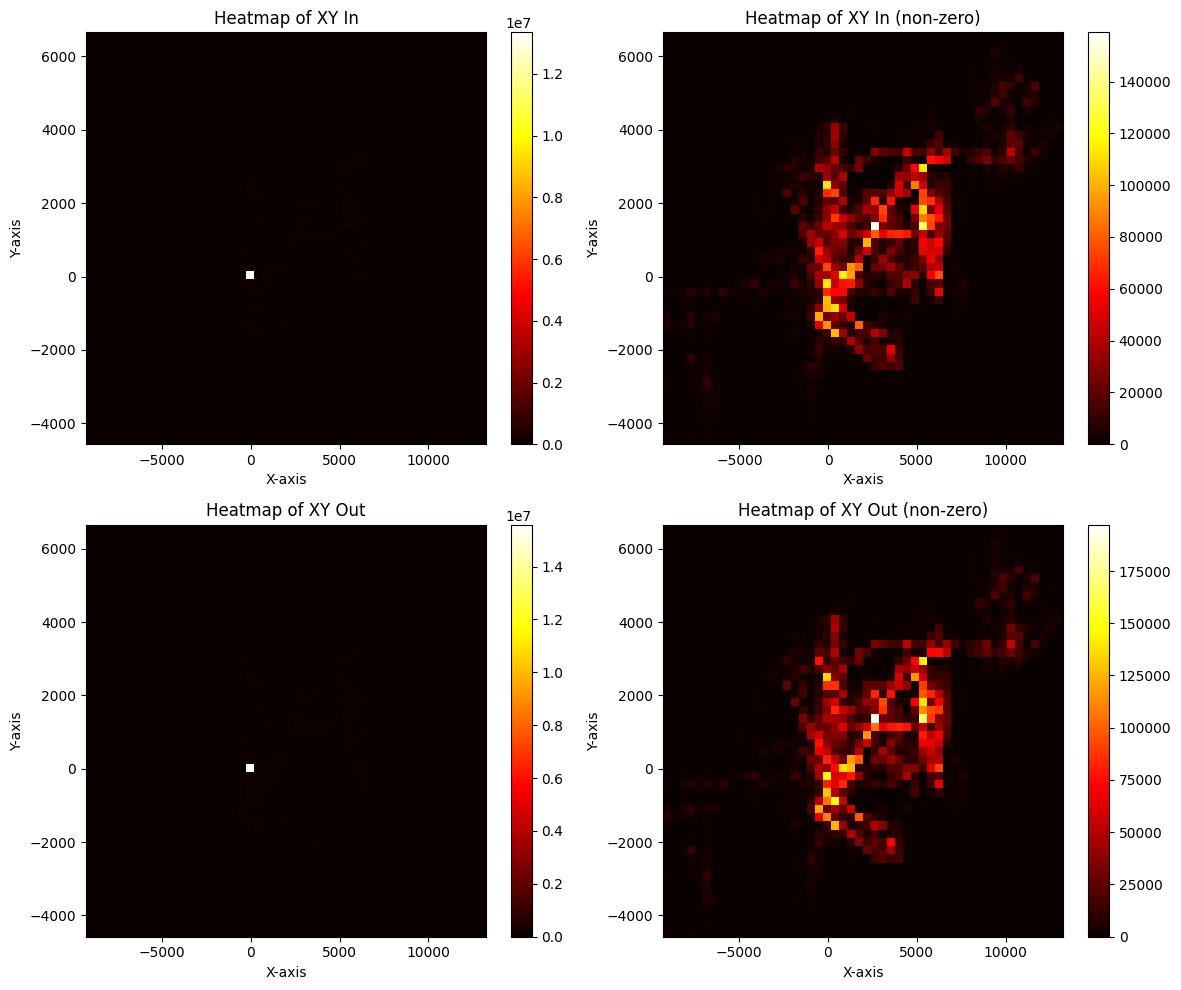

In [6]:
plot_heatmap_subplot(
    data_list=[xy_in, xy_in_not_0, xy_out, xy_out_not_0],
    titles=[
        'Heatmap of XY In',
        'Heatmap of XY In (non-zero)',
        'Heatmap of XY Out',
        'Heatmap of XY Out (non-zero)'
    ],
    bins=50
)

In [7]:
num_samples, num_agents, _, _ = train_data.shape
agent_presence = np.zeros(num_agents, dtype=int)

for i in range(num_samples):
    for j in range(num_agents):
        if np.any(train_data[i, j, :, :2] != 0):
            agent_presence[j] += 1

agent_stats = pd.DataFrame({
    'Agent ID': np.arange(num_agents),
    'Presence Count': agent_presence,
    'Presence Ratio': agent_presence / num_samples
})

In [8]:
print(agent_stats.head())

   Agent ID  Presence Count  Presence Ratio
0         0           10000          1.0000
1         1            9999          0.9999
2         2            9996          0.9996
3         3            9993          0.9993
4         4            9989          0.9989


# Precense Ratio

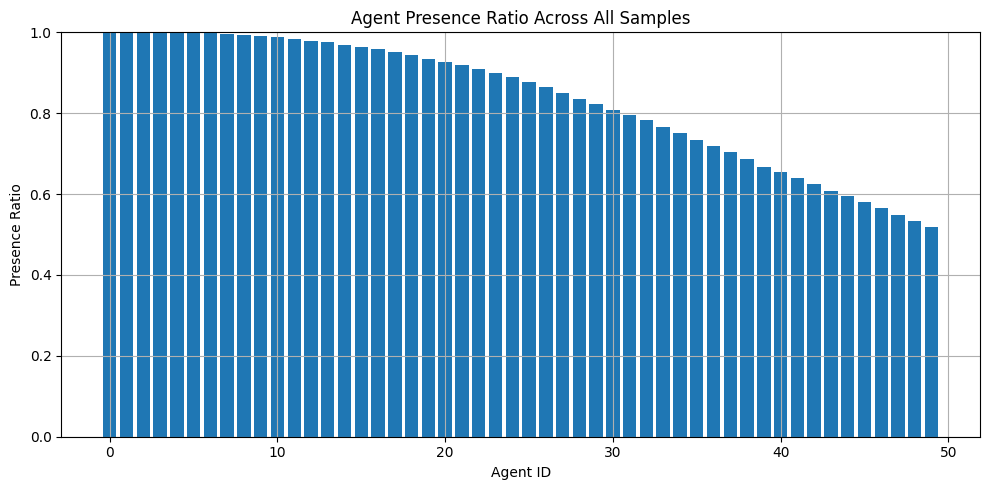

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(agent_stats['Agent ID'], agent_stats['Presence Ratio'])
plt.title('Agent Presence Ratio Across All Samples')
plt.xlabel('Agent ID')
plt.ylabel('Presence Ratio')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def analyze_behavior_by_density(train_data, radius=2.0, frames=50, density_threshold=2):
    """
    classification based on neighbor count within a specified radius
    """
    import numpy as np
    import pandas as pd

    high_density_lengths = []
    low_density_lengths = []
    high_density_speeds = []
    low_density_speeds = []

    for sample in train_data:
        for t in range(frames):
            positions = sample[:, t, :2]  # shape: (num_agents, 2)
            for i in range(positions.shape[0]):
                if np.all(positions[i] == 0):
                    continue
                dists = np.linalg.norm(positions - positions[i], axis=1)
                neighbor_count = np.sum((dists < radius) & (dists > 0))

                traj = sample[i, :frames, :2]
                mask = np.any(traj != 0, axis=1)
                valid_traj = traj[mask]

                if len(valid_traj) < 2:
                    continue

                traj_length = np.sum(np.linalg.norm(np.diff(valid_traj, axis=0), axis=1))

                avg_speed = traj_length / (len(valid_traj) - 1)

                if neighbor_count >= density_threshold:
                    high_density_lengths.append(traj_length)
                    high_density_speeds.append(avg_speed)
                else:
                    low_density_lengths.append(traj_length)
                    low_density_speeds.append(avg_speed)

    summary = {
        'Metric': ['Trajectory Length', 'Average Speed'],
        'High-Density Mean': [np.mean(high_density_lengths), np.mean(high_density_speeds)],
        'Low-Density Mean': [np.mean(low_density_lengths), np.mean(low_density_speeds)],
        'High-Density Median': [np.median(high_density_lengths), np.median(high_density_speeds)],
        'Low-Density Median': [np.median(low_density_lengths), np.median(low_density_speeds)],
    }

    return pd.DataFrame(summary)

## High-Density vs Low-Density Agent Behavior Analysis

We analyzed the behavior of agents in **high neighbor density (≥2)** vs **low neighbor density (<2)** conditions, comparing their average trajectory length and speed:

| Metric           | High-Density Mean | Low-Density Mean | High-Density Median | Low-Density Median |
|------------------|-------------------|------------------|----------------------|---------------------|
| Trajectory Length | 2.46              | 11.59            | 1.35                 | 1.94                |
| Average Speed     | 0.063             | 0.276            | 0.037                | 0.054               |

---

### Interpretation:

1. **Trajectory Length**
   - Agents in high-density settings only move ~2.5 meters on average, compared to over 11 meters for low-density agents.
   - This suggests limited mobility in crowded scenes — likely due to congestion or close-range interactions.

2. **Average Speed**
   - High-density agents move much slower (~0.06 units/frame), often almost stationary.
   - Low-density agents move faster and more freely.

3. **Median vs Mean**
   - The median for high-density agents is even lower than the mean, indicating most are nearly static, with a few outliers moving more.
   - Low-density agents have a more balanced distribution.

---

### Conclusion:

> **Agents in crowded environments move less and slower**, while those in sparse contexts travel further and faster. High-density behavior often represents complex interactions (e.g. at intersections, near crosswalks).

---

In [ ]:
def plot_high_low_density_agents(train_data, sample_index=0, radius=2.0, frames=50, density_threshold=2):
    sample = train_data[sample_index]
    positions = sample[:, :frames, :2]  # shape: (num_agents, frames, 2)

    high_density_agents = []
    low_density_agents = []

    t = 0
    for i in range(positions.shape[0]):
        pos_i = positions[i, t]
        if np.all(pos_i == 0):
            continue
        dists = np.linalg.norm(positions[:, t] - pos_i, axis=1)
        neighbor_count = np.sum((dists < radius) & (dists > 0))

        if neighbor_count >= density_threshold:
            high_density_agents.append(i)
        else:
            low_density_agents.append(i)

    # plot
    plt.figure(figsize=(8, 8))

    for i in low_density_agents:
        traj = positions[i]
        if np.all(traj == 0): continue
        plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.5, label='Low-density' if i == low_density_agents[0] else "")

    for i in high_density_agents:
        traj = positions[i]
        if np.all(traj == 0): continue
        plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.7, label='High-density' if i == high_density_agents[0] else "")

    plt.title(f"Agent Trajectories in Sample {sample_index}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()